In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
import topojson as tp
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
import io
import base64
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyproj
import pysal
import geopandas as gpd
import mgwr
import seaborn as sns 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

To begin, the path to the census 2021 files are defined in the code cell below, and it will load all of the dataframes and merge them on the common columns, which are cx, cy, areaName and code. Once that's been done, the dependent and independent variables will be separated.

In [2]:
# Paths to CSV files
file_paths = {
    "accommodation_Ward": "accommodation_Ward.csv",
    "deprivation_Ward": "deprivation_Ward.csv",
    "health_Ward": "health_Ward.csv",
    "occupation_Ward": "occupation_Ward.csv",
    "pop_Ward": "pop_Ward.csv",
    "popDensity_Ward": "popDensity_Ward.csv",
    "qualification_Ward": "qualification_Ward.csv",
    "socioEcon_Ward": "socioEcon_Ward.csv",
    "vehicle_Ward": "vehicle_Ward.csv",
    "ethnicgroup_Ward": "ethnicGroup_Ward.csv",
    "heating_Ward": "heating_Ward.csv",
    "sex_Ward": "sex_Ward.csv"
}

# Load all dataframes
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Merge all dataframes on common columns
common_columns = ['cx', 'cy', 'areaName', 'code']
merged_df = pd.DataFrame()
for name, df in dataframes.items():
    if merged_df.empty:
        # If merged_df is empty, initialize it with the first dataframe
        merged_df = df
    else:
        # Merge subsequent dataframes
        merged_df = merged_df.merge(df, on=common_columns, how='inner')

# Separate dependent and independent variables
dependent_vars = dataframes['health_Ward'].columns.difference(common_columns)
independent_vars = merged_df.columns.difference(dependent_vars).difference(common_columns)

print("Dependent Variables:", dependent_vars)
print("Independent Variables:", independent_vars)

# Display the first few rows of the merged DataFrame
print(merged_df.head())


Dependent Variables: Index(['N/A', 'bad', 'fair', 'good', 'vBad', 'vGood'], dtype='object')
Independent Variables: Index(['2plusNonRenewable', '2plusRenewable', 'ABAsian', 'ABBangladeshi',
       'ABChinese', 'ABIndian', 'ABPakistani', 'BBAfrican', 'BBBlack',
       'BBCaribbean', 'L10_L11', 'L12', 'L13', 'L14', 'L15', 'L1_L2_L3',
       'L4_L5_L6', 'L7', 'L8_L9', 'N/A_x', 'N/A_y', 'admin', 'apprentice',
       'arab', 'bottledGas', 'caravan', 'commercial', 'communal', 'conversion',
       'dep0', 'dep1', 'dep2', 'dep3', 'dep4', 'detached', 'elec',
       'elementary', 'female', 'flats', 'level1', 'level2', 'level3', 'level4',
       'mainsGas', 'male', 'management', 'manual', 'multiple', 'none_x',
       'none_y', 'oil', 'other', 'other_x', 'other_y', 'popDensity',
       'population', 'professional', 'renewable', 'sales', 'semiDetached',
       'service', 'sharedHouse', 'skilledTrade', 'solid', 'technical',
       'terraced', 'v0', 'v1', 'v2', 'v3plus', 'wBritish', 'wIrish', 'wOther'

Once they've been merged, we print the new dataframe called merged_df to see if everything's working fine. If everything is in order, merged_df will be saved as merged_data.csv in the folder.

In [3]:
# Save the merged DataFrame as a CSV file
merged_df.to_csv('merged_data.csv', index=False)


When manually inspecting the newly merged dataframe, we find that there are multiple occurrences of N/A_x and N/A_y in the dataframe, so manual grouping had to be done to check which N/A belonged to which group. Once that's done, we renamed them in the order they appeared, so that they get named with the correct indicator groups they belonged to. 

In [4]:
# New names for the duplicated columns, in the order they appear
new_names = {
    'N/A_x': ['N/A_deprivation', 'N/A_occupation', 'N/A_socioecon', 'N/A_ethnic'],  
    'N/A_y': ['N/A_health', 'N/A_qualification', 'N/A_vehicle', 'N/A_heating']   
}

# Rename duplicated columns in merged_df
new_columns = []
name_counters = {key: 0 for key in new_names}

for col in merged_df.columns:
    if col in new_names:
        new_columns.append(new_names[col][name_counters[col]])
        name_counters[col] += 1
    else:
        new_columns.append(col)

merged_df.columns = new_columns

# Display the DataFrame to verify changes
print(merged_df)


           code                 areaName      cx      cy  detached  \
0     E05000650            Astley Bridge  370732  412836      1297   
1     E05000653            Bromley Cross  371904  414137      2221   
2     E05000654          Crompton Bolton  371830  410799       497   
3     E05000657                Halliwell  370801  409673       303   
4     E05000658             Harper Green  371585  406271       330   
...         ...                      ...     ...     ...       ...   
7633  E05013624            Hounslow West  512415  175616       288   
7634  W05001064                   Sketty  262079  192667      2114   
7635  W05001443    Fishguard: North West  195186  236703       233   
7636  W05001455               Letterston  193040  226803       580   
7637  W05001479  Pembroke: St Mary North  198554  202137       241   

      semiDetached  terraced  flats  sharedHouse  conversion  ...  oil  wood  \
0             2252      1689    423           42         216  ...   14     3   

After the renaming is complete, we save the df with a new name merged_data_final.csv

In [5]:
# Save the merged DataFrame as a CSV file
merged_df.to_csv('merged_data_final.csv', index=False)


In [6]:
# Adjusted indicators being grouped based on their starting columns
indicator_groups = {
    'accommodation': 'detached',
    'deprivation': 'N/A_deprivation',
    'health': 'N/A_health',
    'occupation': 'N/A_occupation',
    'qualification': 'N/A_qualification',
    'socioeconomics': 'N/A_socioecon',
    'vehicle': 'N/A_vehicle',
    'ethnicgroup': 'N/A_ethnic',
    'heating': 'N/A_heating',
    'pop': 'population',  
    'popdensity': 'popDensity',  
    'sex': 'female'
    
}

# Function to find the current indicator based on the column name
def find_current_indicator(column, indicator_groups):
    for indicator, start_col in indicator_groups.items():
        if column == start_col:
            return indicator
    return None

# Initialize variables
current_indicator = None
indicator_columns = {ind: [] for ind in indicator_groups.keys()}

# Iterate over columns and assign them to the correct indicator
for col in merged_df.columns:
    new_indicator = find_current_indicator(col, indicator_groups)
    if new_indicator:
        current_indicator = new_indicator
    if current_indicator:
        indicator_columns[current_indicator].append(col)

# Now, indicator_columns dictionary contains the columns for each indicator
for indicator, columns in indicator_columns.items():
    print(f"Indicator: {indicator}, Columns: {columns}")


Indicator: accommodation, Columns: ['detached', 'semiDetached', 'terraced', 'flats', 'sharedHouse', 'conversion', 'commercial', 'caravan']
Indicator: deprivation, Columns: ['N/A_deprivation', 'dep0', 'dep1', 'dep2', 'dep3', 'dep4']
Indicator: health, Columns: ['N/A_health', 'vGood', 'good', 'fair', 'bad', 'vBad']
Indicator: occupation, Columns: ['N/A_occupation', 'management', 'professional', 'technical', 'admin', 'skilledTrade', 'service', 'sales', 'manual', 'elementary']
Indicator: qualification, Columns: ['N/A_qualification', 'none_x', 'level1', 'level2', 'apprentice', 'level3', 'level4', 'other_x']
Indicator: socioeconomics, Columns: ['N/A_socioecon', 'L1_L2_L3', 'L4_L5_L6', 'L7', 'L8_L9', 'L10_L11', 'L12', 'L13', 'L14', 'L15']
Indicator: vehicle, Columns: ['N/A_vehicle', 'v0', 'v1', 'v2', 'v3plus']
Indicator: ethnicgroup, Columns: ['N/A_ethnic', 'ABBangladeshi', 'ABChinese', 'ABIndian', 'ABPakistani', 'ABAsian', 'BBAfrican', 'BBCaribbean', 'BBBlack', 'whiteAndAsian', 'whiteAndBlac

On careful observation of the columns above, it is decided to remove the N/A columns as they do not provide any explanatory impact to the analysis and modeling, it also removes noise from the analysis. Besides that, some columns were vaguely named and to avoid confusion in interpreting the results of the analysis, they are renamed to more aptly fit the indicators they belong to.

In [7]:
# Dropping the specified columns
columns_to_drop = [
    'N/A_deprivation', 'N/A_health', 'N/A_occupation', 'N/A_qualification',
    'N/A_socioecon', 'N/A_vehicle', 'N/A_ethnic', 'N/A_heating'
]
merged_df.drop(columns=columns_to_drop, inplace=True)

# Renaming the specified columns
columns_to_rename = {
    'none_y': 'none_heating',
    'none_x': 'none_qualification',
    'other_y': 'other_ethnic',
    'other_x': 'other_qualification',
    'other': 'other_heating'
}
merged_df.rename(columns=columns_to_rename, inplace=True)

merged_df.head()  # Display the first few rows of the modified DataFrame


,code,areaName,cx,cy,detached,semiDetached,terraced,flats,sharedHouse,conversion,...,oil,wood,solid,renewable,communal,other_heating,2plusNonRenewable,2plusRenewable,female,male
0,E05000650,Astley Bridge,370732,412836,1297,2252,1689,423,42,216,...,14,3,4,1,23,47,428,15,7193,6948
1,E05000653,Bromley Cross,371904,414137,2221,1739,1527,299,21,146,...,12,1,1,6,5,17,421,15,7051,6595
2,E05000654,Crompton Bolton,371830,410799,497,1496,3362,1215,49,36,...,23,0,4,4,43,100,591,8,8813,8770
3,E05000657,Halliwell,370801,409673,303,820,2986,1796,174,41,...,2,2,4,5,144,142,500,9,7876,8389
4,E05000658,Harper Green,371585,406271,330,3530,1158,360,43,1,...,1,1,5,4,14,84,452,7,8274,7929


After removing the N/A columns, the indicator groups had to be adjusted based on their new starting columns and we print the indicator dictionary to see what each group contains.

In [8]:
# Adjusted indicators being grouped based on their starting columns
indicator_groups = {
    'accommodation': 'detached',
    'deprivation': 'dep0',
    'health': 'vGood',
    'occupation': 'management',
    'qualification': 'none_qualification',
    'socioeconomics': 'L1_L2_L3',
    'vehicle': 'v0',
    'ethnicgroup': 'ABBangladeshi',
    'heating': 'none_heating',
    'pop': 'population',  
    'popdensity': 'popDensity',  
    'sex': 'female'
    
}

# Function to find the current indicator based on the column name
def find_current_indicator(column, indicator_groups):
    for indicator, start_col in indicator_groups.items():
        if column.startswith(start_col):
            return indicator
    return None

# Initialize variables
current_indicator = None
indicator_columns = {ind: [] for ind in indicator_groups.keys()}

# Iterate over columns and assign them to the correct indicator
for col in merged_df.columns:
    new_indicator = find_current_indicator(col, indicator_groups)
    if new_indicator:
        current_indicator = new_indicator
    if current_indicator:
        indicator_columns[current_indicator].append(col)

# Now, indicator_columns dictionary contains the columns for each indicator
for indicator, columns in indicator_columns.items():
    print(f"Indicator: {indicator}, Columns: {columns}")


Indicator: accommodation, Columns: ['detached', 'semiDetached', 'terraced', 'flats', 'sharedHouse', 'conversion', 'commercial', 'caravan']
Indicator: deprivation, Columns: ['dep0', 'dep1', 'dep2', 'dep3', 'dep4']
Indicator: health, Columns: ['vGood', 'good', 'fair', 'bad', 'vBad']
Indicator: occupation, Columns: ['management', 'professional', 'technical', 'admin', 'skilledTrade', 'service', 'sales', 'manual', 'elementary']
Indicator: qualification, Columns: ['none_qualification', 'level1', 'level2', 'apprentice', 'level3', 'level4', 'other_qualification']
Indicator: socioeconomics, Columns: ['L1_L2_L3', 'L4_L5_L6', 'L7', 'L8_L9', 'L10_L11', 'L12', 'L13', 'L14', 'L15']
Indicator: vehicle, Columns: ['v0', 'v1', 'v2', 'v3plus']
Indicator: ethnicgroup, Columns: ['ABBangladeshi', 'ABChinese', 'ABIndian', 'ABPakistani', 'ABAsian', 'BBAfrican', 'BBCaribbean', 'BBBlack', 'whiteAndAsian', 'whiteAndBlackAfrican', 'whiteAndBlackCaribbean', 'multiple', 'wBritish', 'wIrish', 'wTraveller', 'wRoma', 

Now that the data pre-processing stage is satisfactory, some initial explanatory data exploration (EDA) analysis will be executed and the visualizations of the distribution and the nature of the data will be displayed to further understand what needs to be done with the data prior to modeling and further analysis.

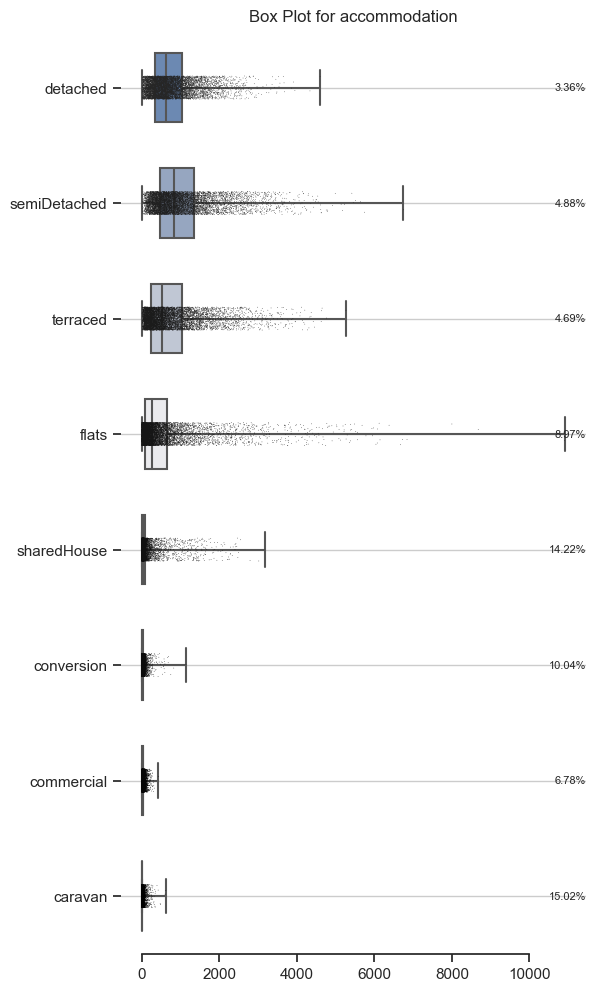

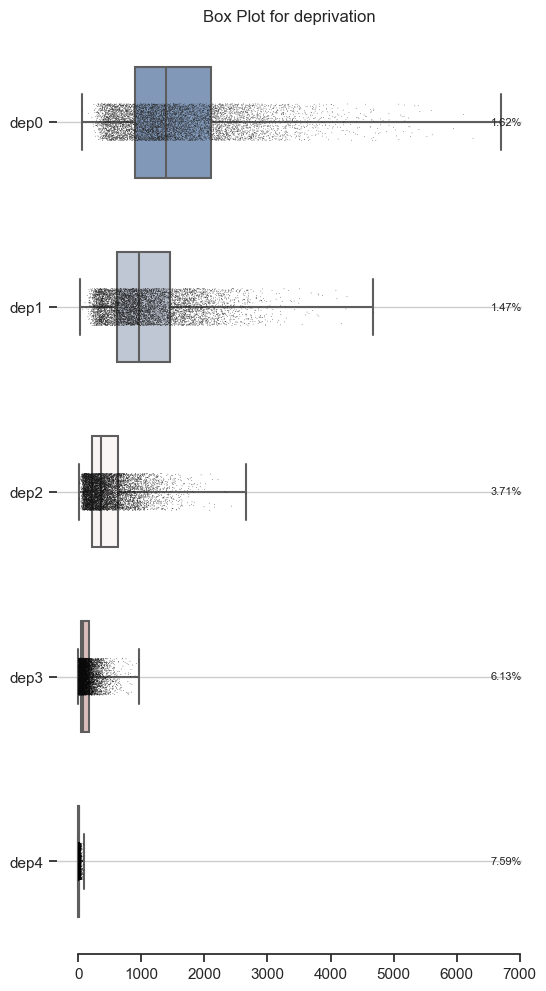

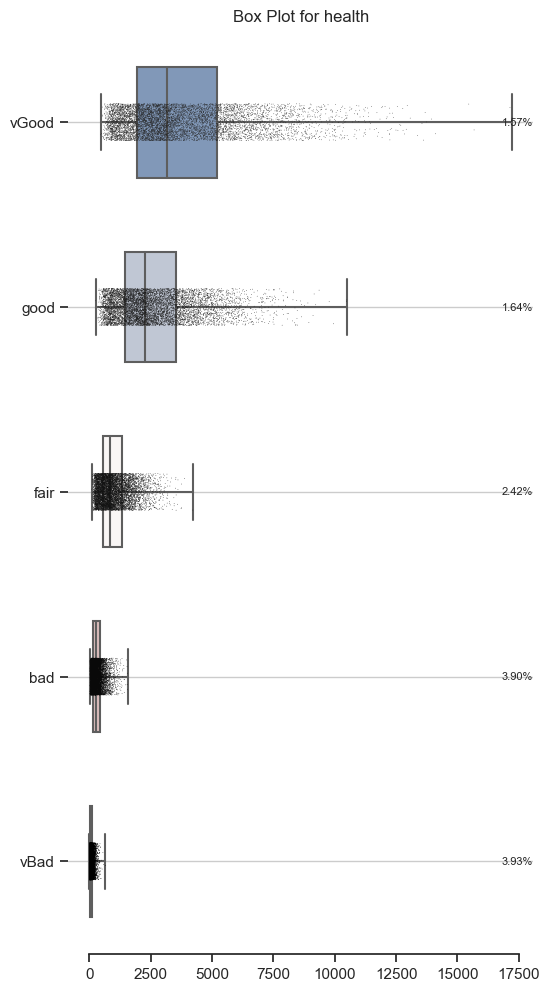

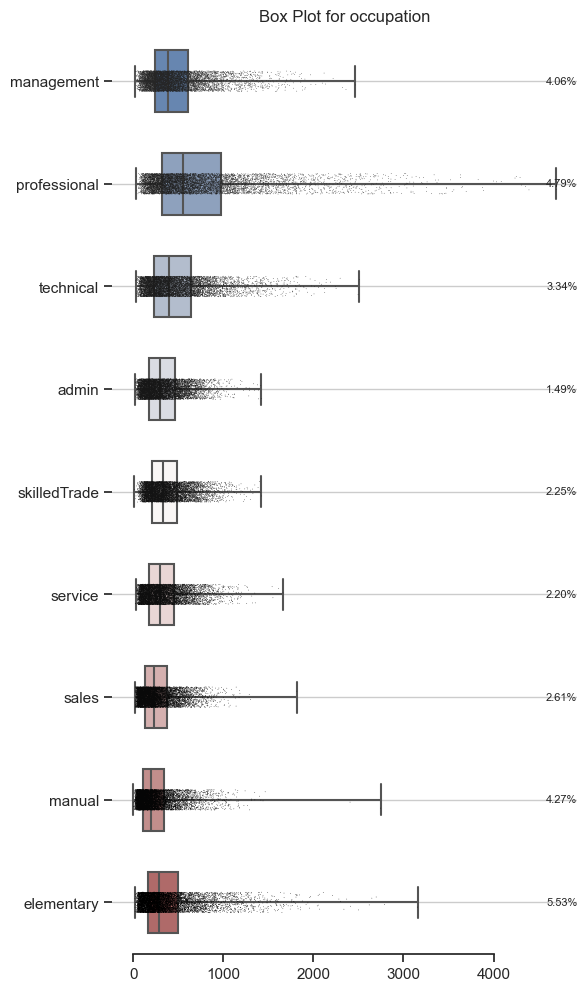

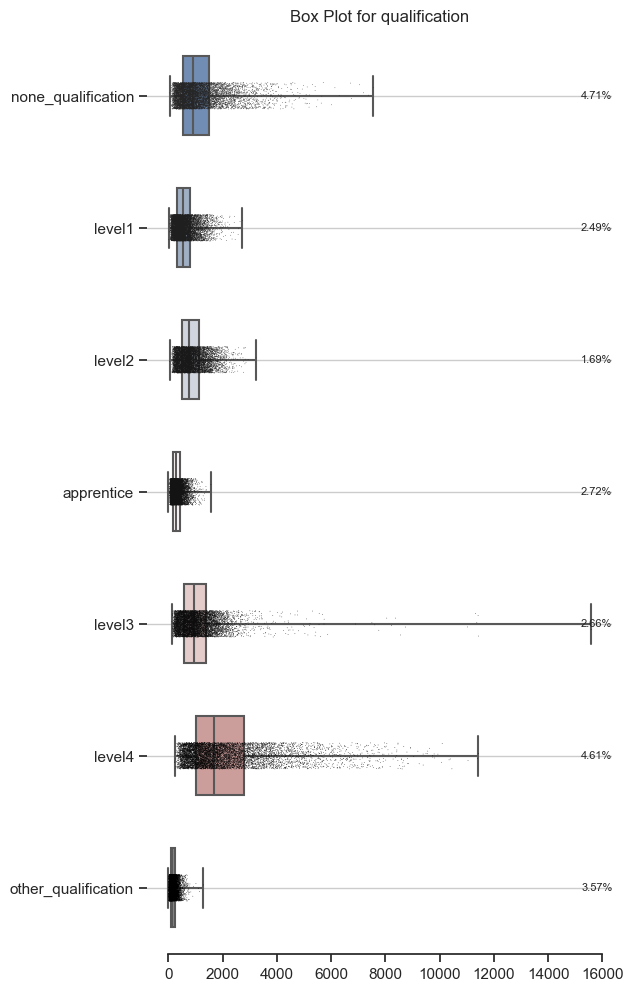

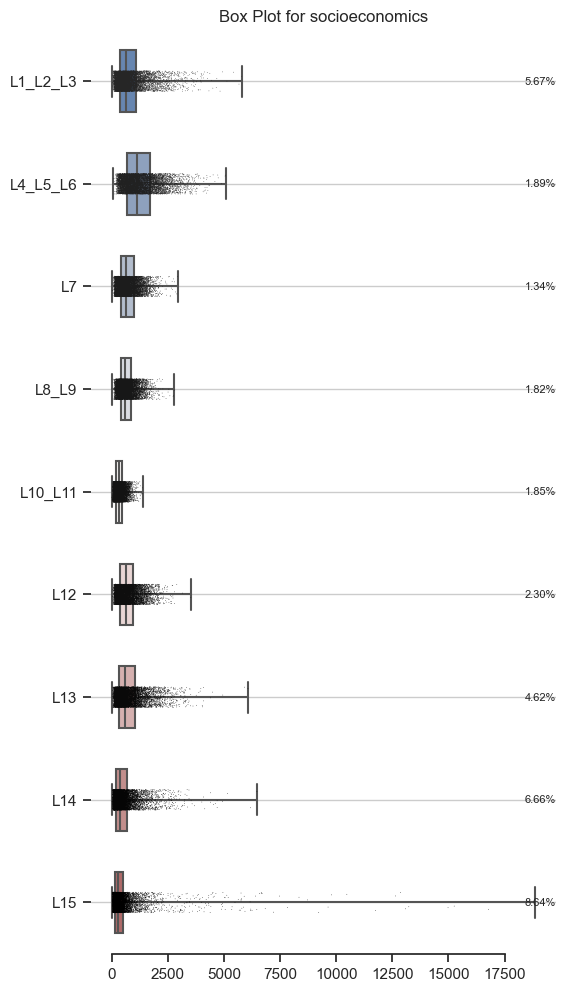

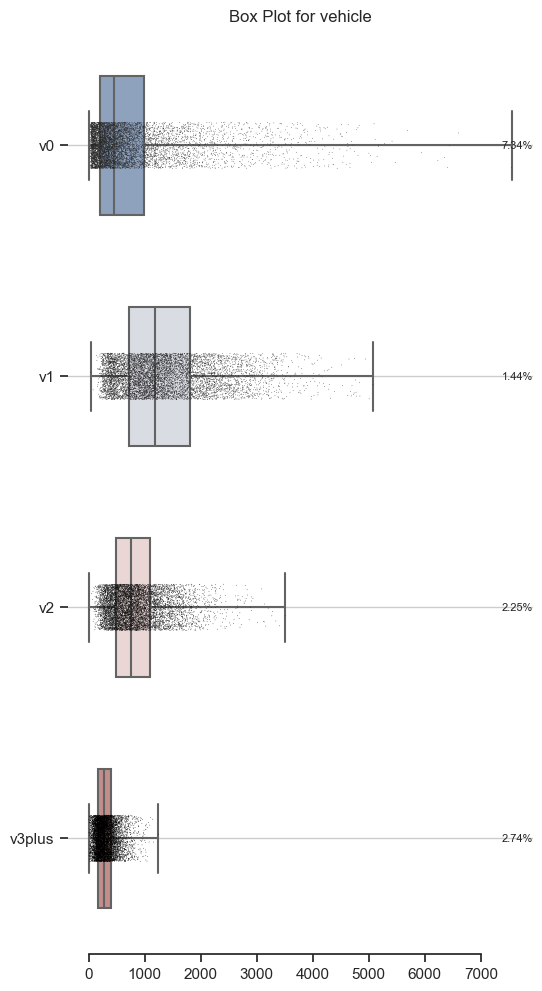

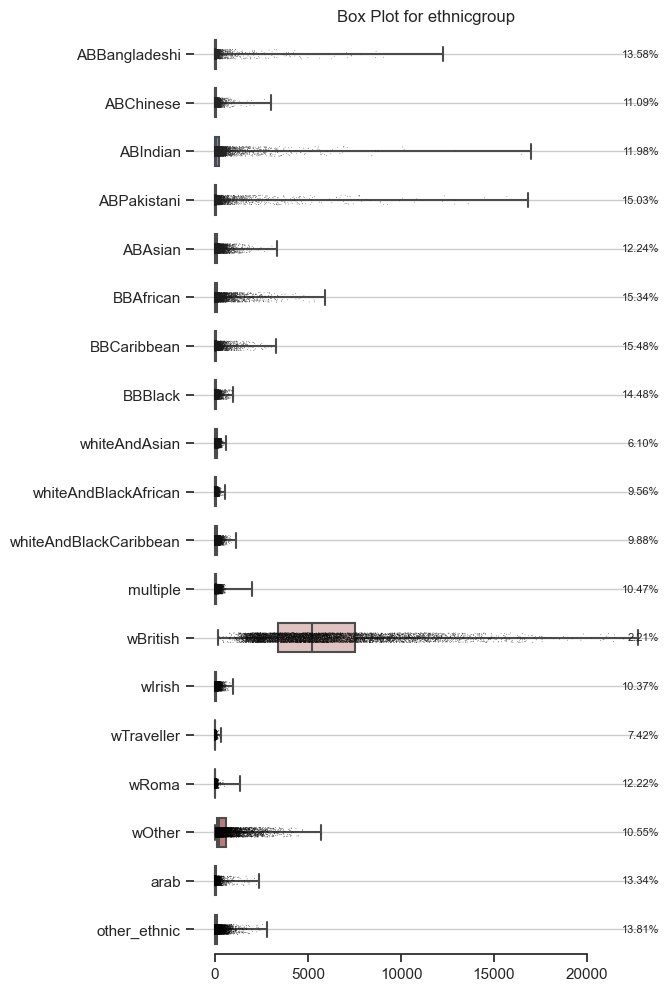

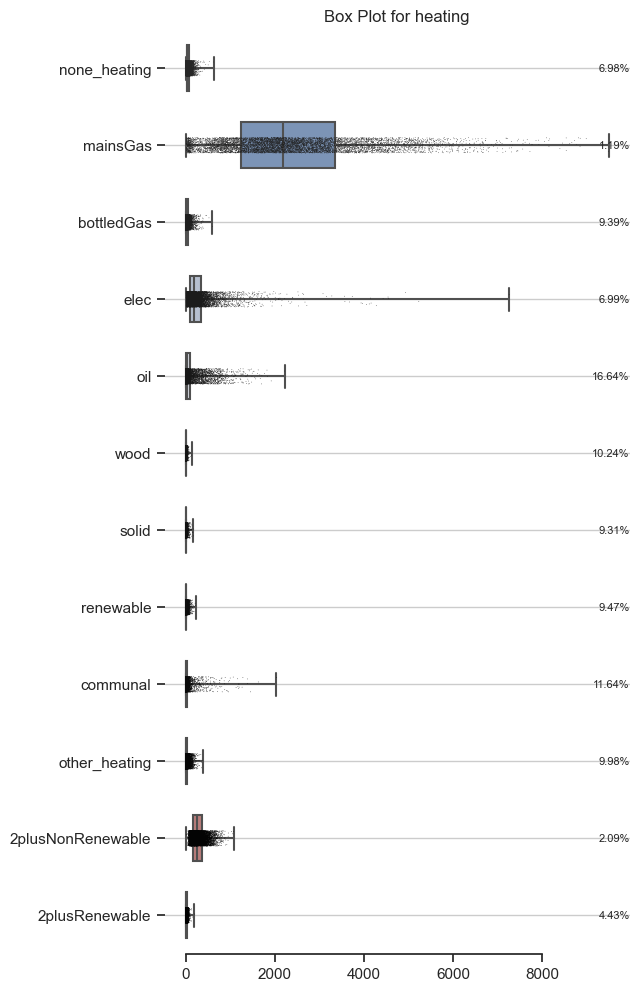

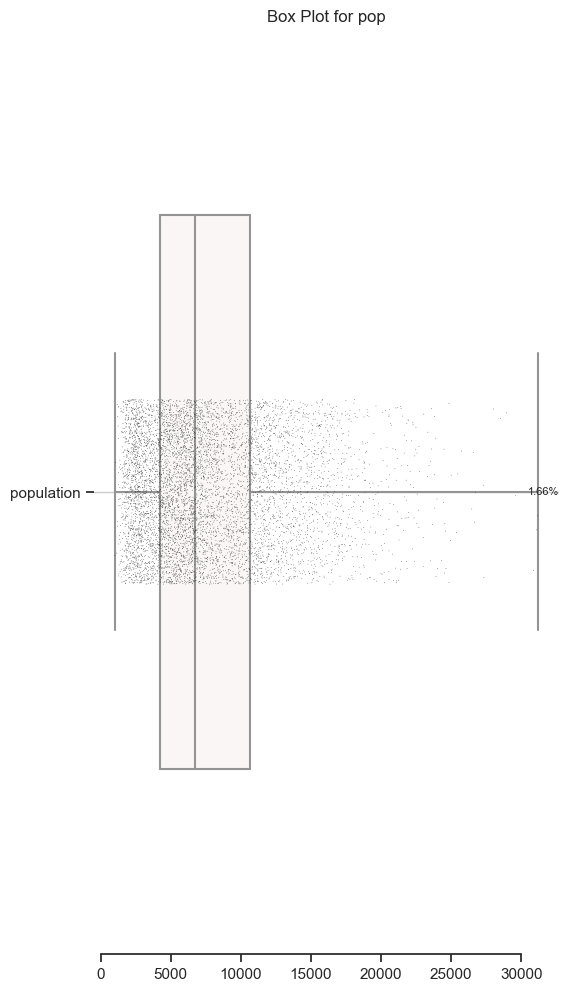

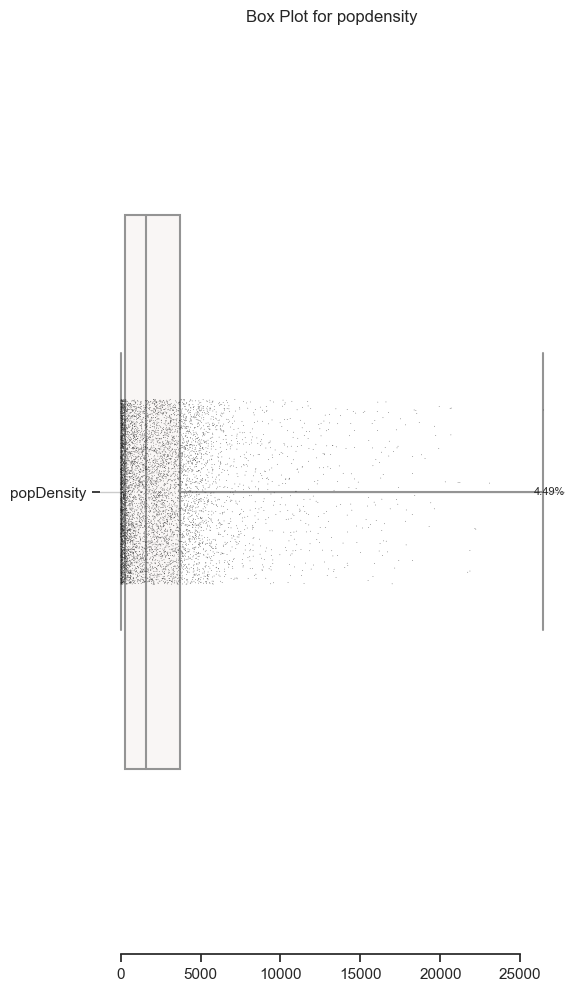

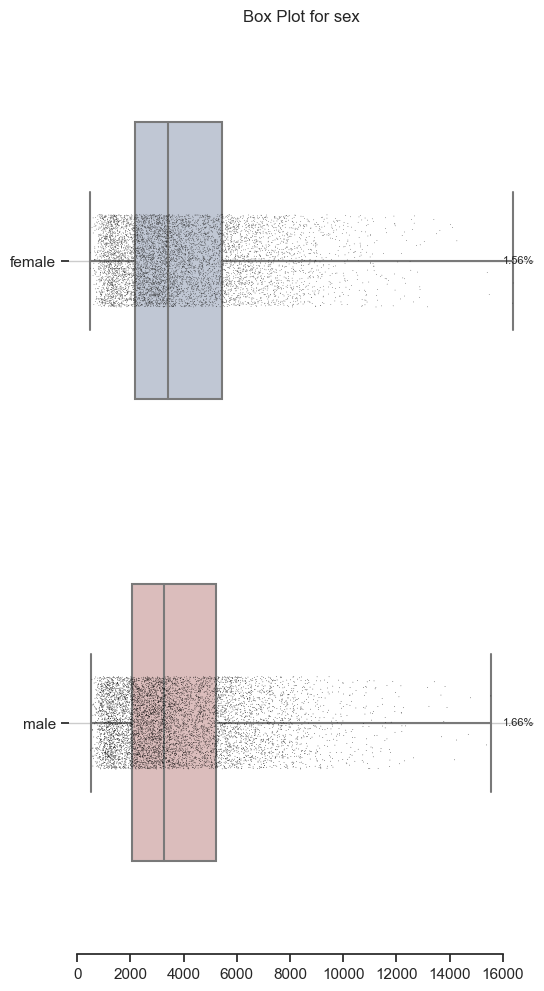

In [9]:
# Function to calculate the percentage of outliers
def percentage_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    total_count = data.count()
    return (outlier_count / total_count) * 100

# Set the style of the visualization
sns.set_theme(style="ticks")

# Iterate over each indicator and plot the box plot
for indicator, columns in indicator_columns.items():
    f, ax = plt.subplots(figsize=(6, 12))

    # Plot the box plot horizontally
    sns.boxplot(data=merged_df[columns], whis=[0, 100], width=.6, palette="vlag", orient='h')

    # Add in points to show each observation
    sns.stripplot(data=merged_df[columns], size=0.5, color="black", orient='h')

    # Set titles and labels
    ax.set_title(f'Box Plot for {indicator}')
    ax.set_yticklabels(columns, rotation=0)
    ax.yaxis.grid(True)
    ax.set(xlabel="")
    sns.despine(trim=True, left=True)

    # Annotating the percentage of outliers for each column
    for i, col in enumerate(columns):
        outlier_percentage = percentage_outliers(merged_df[col])
        plt.text(ax.get_xlim()[1], i, f'{outlier_percentage:.2f}%', ha='right', va='center', fontsize=8)

    plt.show()


The above contains boxplots which visualizes the presence of outliers in the data, with the percentage of outliers in the total population being annotated at the end of each individual boxplot, this helps to clarify the understanding of the data with clear numbers to judge with. 

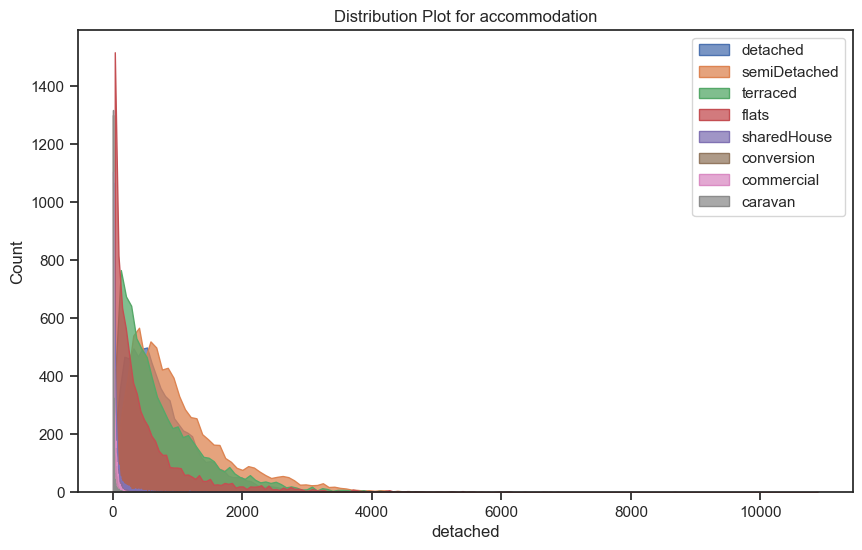

Skewness for accommodation:
{'detached': 1.412357129346818, 'semiDetached': 1.6269082433071786, 'terraced': 1.7726697536311873, 'flats': 3.4533428750919457, 'sharedHouse': 4.8698336301266005, 'conversion': 7.055699200853575, 'commercial': 2.9593192416998457, 'caravan': 6.119882155889503}
Kurtosis for accommodation:
{'detached': 2.7541305645193574, 'semiDetached': 3.480955873605441, 'terraced': 3.897807605489181, 'flats': 17.44905913501552, 'sharedHouse': 28.732389969211788, 'conversion': 83.38626801749794, 'commercial': 13.11569183788458, 'caravan': 57.76171749640477}




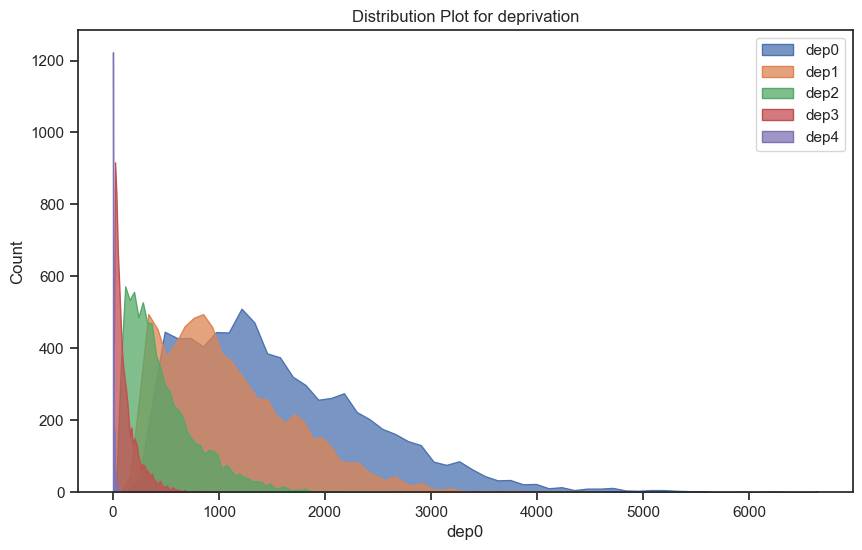

Skewness for deprivation:
{'dep0': 1.026449515361245, 'dep1': 0.9681149740968937, 'dep2': 1.4339147879601348, 'dep3': 2.0733604241430745, 'dep4': 2.5709537666547475}
Kurtosis for deprivation:
{'dep0': 1.2847849075645748, 'dep1': 0.9749629463317877, 'dep2': 2.4473070771174816, 'dep3': 5.6144116058887885, 'dep4': 8.72122883406684}




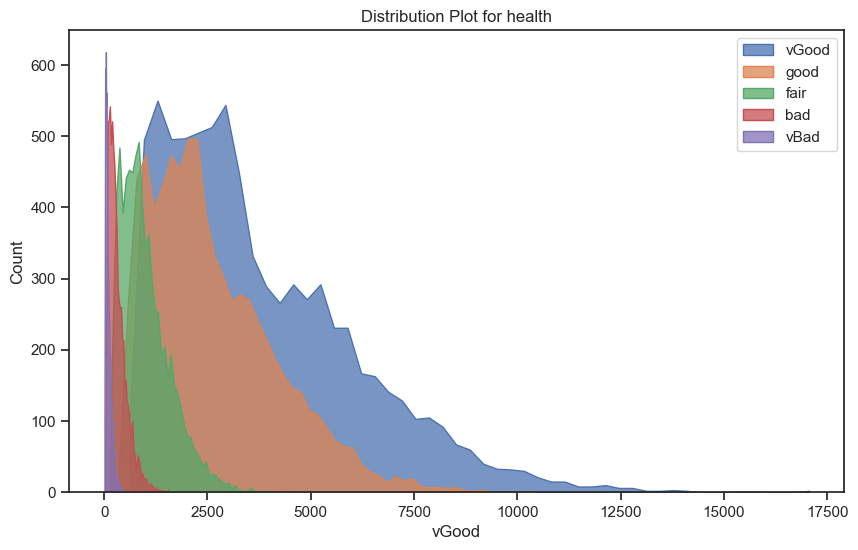

Skewness for health:
{'vGood': 1.061171613418143, 'good': 0.9923624845856028, 'fair': 1.1041849293493025, 'bad': 1.4874140377880272, 'vBad': 1.6861331753976514}
Kurtosis for health:
{'vGood': 1.0808067457185908, 'good': 0.920446986194333, 'fair': 1.2936249299799183, 'bad': 2.752753011709606, 'vBad': 3.9393460084100242}




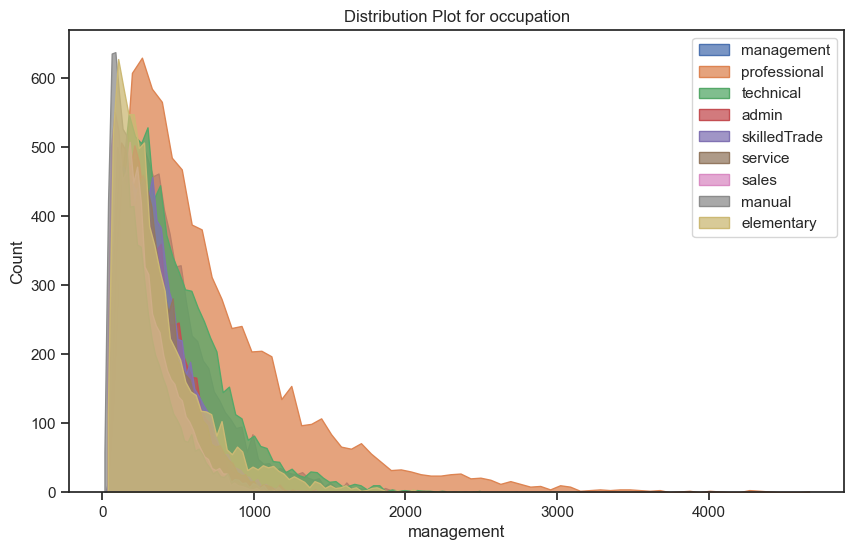

Skewness for occupation:
{'management': 1.5161141515446237, 'professional': 1.840496449728397, 'technical': 1.4576065186545355, 'admin': 0.9973420032082342, 'skilledTrade': 1.0623135811042683, 'service': 1.1430422295618785, 'sales': 1.2564343467307497, 'manual': 1.9147214851364722, 'elementary': 2.0584723572293098}
Kurtosis for occupation:
{'management': 3.1620179246490494, 'professional': 4.576804890310129, 'technical': 2.889508251918344, 'admin': 1.0420425519191054, 'skilledTrade': 1.2201410794035228, 'service': 1.602166266902871, 'sales': 2.037034119229806, 'manual': 7.133181414408805, 'elementary': 6.3216115295757405}




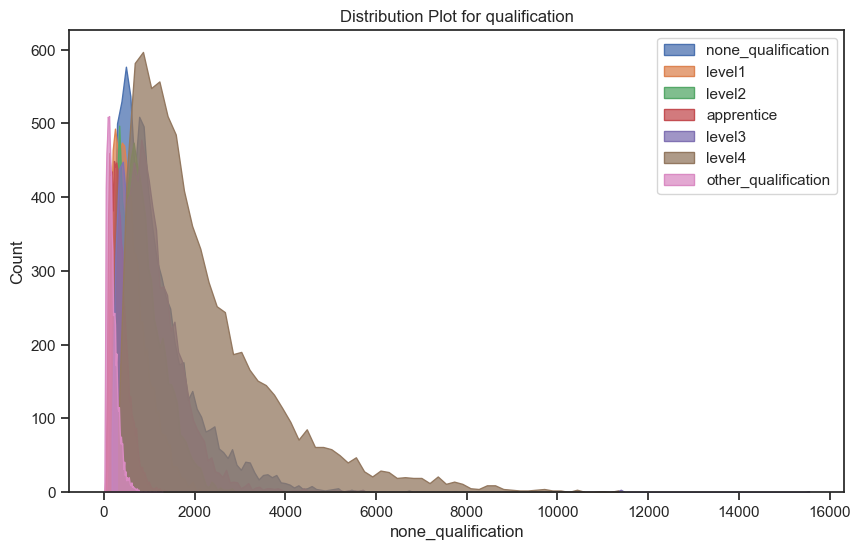

Skewness for qualification:
{'none_qualification': 1.7828745756466189, 'level1': 1.144770705866794, 'level2': 0.9160546194498, 'apprentice': 1.214178939461486, 'level3': 4.439042692322603, 'level4': 1.6650434186325729, 'other_qualification': 1.6940584640316847}
Kurtosis for qualification:
{'none_qualification': 4.673772539585829, 'level1': 1.4608629619983882, 'level2': 0.683707846598339, 'apprentice': 1.9657036939470842, 'level3': 48.022714573606, 'level4': 3.4167653814555043, 'other_qualification': 4.8361769394044005}




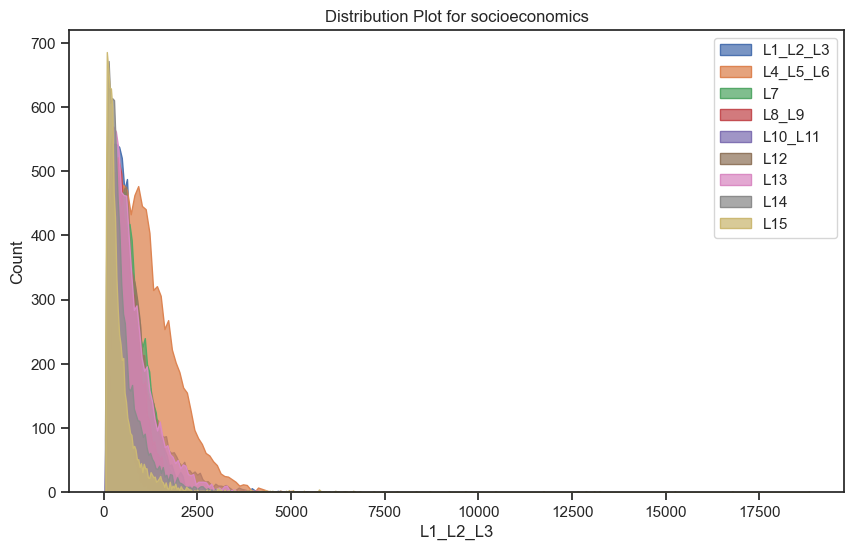

Skewness for socioeconomics:
{'L1_L2_L3': 1.930292454503129, 'L4_L5_L6': 1.0314248894748415, 'L7': 0.9286828685913919, 'L8_L9': 1.0902931634018178, 'L10_L11': 1.0266334982101948, 'L12': 1.1012598446196042, 'L13': 1.7860608550095944, 'L14': 2.749750635022721, 'L15': 9.018568496829431}
Kurtosis for socioeconomics:
{'L1_L2_L3': 5.227804158792829, 'L4_L5_L6': 1.1256023875600674, 'L7': 0.8796852529963948, 'L8_L9': 1.5227836875515433, 'L10_L11': 1.1571277875948551, 'L12': 1.3252051046910278, 'L13': 4.90665519022376, 'L14': 12.716600414639434, 'L15': 126.2489496188991}




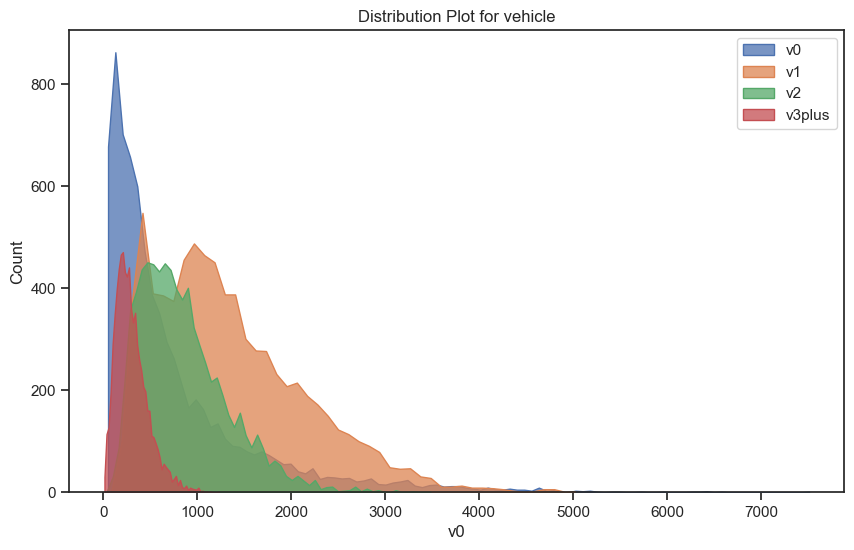

Skewness for vehicle:
{'v0': 2.288646907567161, 'v1': 0.9416240025391359, 'v2': 1.1331115731272872, 'v3plus': 1.1170258454883806}
Kurtosis for vehicle:
{'v0': 6.594397142715332, 'v1': 0.7951289380090039, 'v2': 1.7732326878539517, 'v3plus': 1.658441210725492}




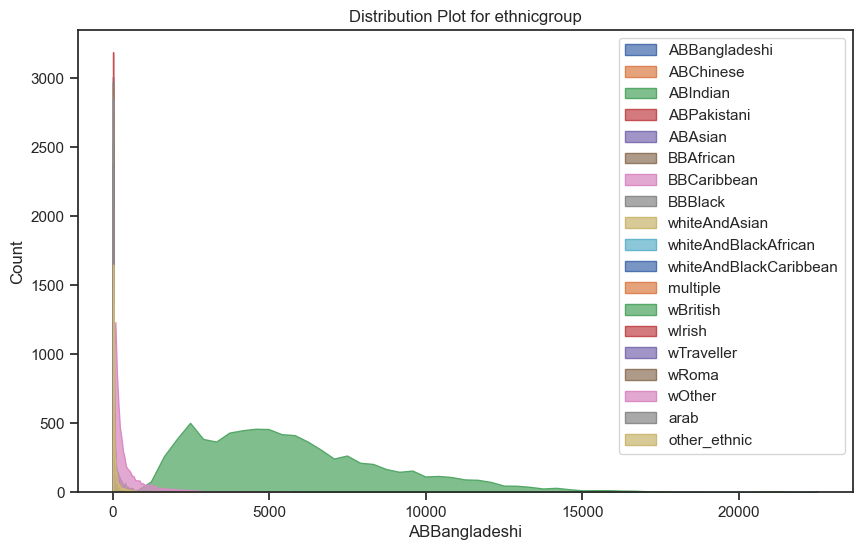

Skewness for ethnicgroup:
{'ABBangladeshi': 12.99915009141311, 'ABChinese': 8.205694058839203, 'ABIndian': 8.900774362081474, 'ABPakistani': 9.297999597461748, 'ABAsian': 4.307014743373966, 'BBAfrican': 4.760301093992233, 'BBCaribbean': 5.681068613859802, 'BBBlack': 4.479076411250165, 'whiteAndAsian': 1.9214241562314804, 'whiteAndBlackAfrican': 2.8959462690948987, 'whiteAndBlackCaribbean': 3.159051007236963, 'multiple': 3.75120396473395, 'wBritish': 1.0851798787099647, 'wIrish': 3.067340495977677, 'wTraveller': 5.7467390513540515, 'wRoma': 13.068527608879508, 'wOther': 2.490971686012457, 'arab': 7.968091078513277, 'other_ethnic': 3.942493631939743}
Kurtosis for ethnicgroup:
{'ABBangladeshi': 224.2003144215607, 'ABChinese': 117.7151264640757, 'ABIndian': 128.12896161483638, 'ABPakistani': 115.73530837286131, 'ABAsian': 26.865816374389983, 'BBAfrican': 30.25970234173103, 'BBCaribbean': 42.78344415702309, 'BBBlack': 25.123999402156862, 'whiteAndAsian': 4.22923429363457, 'whiteAndBlackAfri

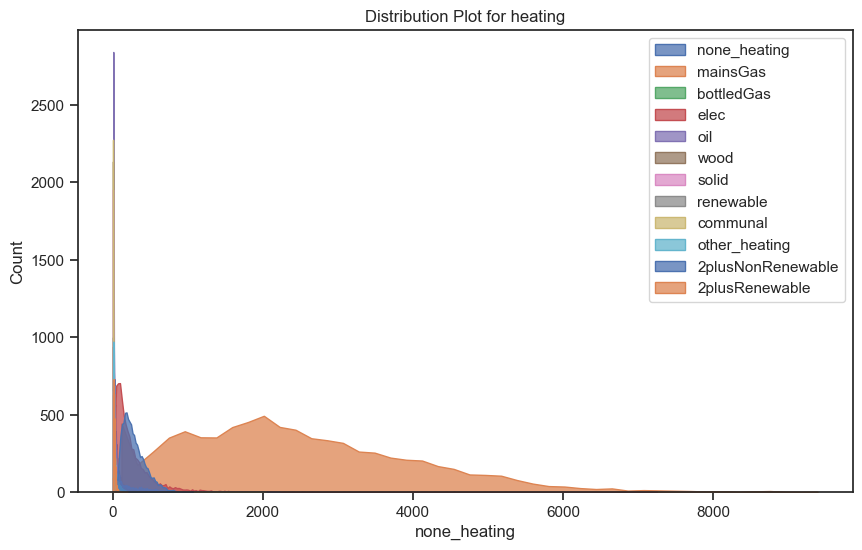

Skewness for heating:
{'none_heating': 2.597561250546285, 'mainsGas': 0.7164051458834501, 'bottledGas': 3.661387536063157, 'elec': 5.571853811717393, 'oil': 3.1395065018364323, 'wood': 4.263762760086681, 'solid': 4.824300788953163, 'renewable': 3.5918043481698154, 'communal': 8.421339641328116, 'other_heating': 2.7820356587651194, '2plusNonRenewable': 1.055950918938447, '2plusRenewable': 2.314071891523959}
Kurtosis for heating:
{'none_heating': 11.394640977129935, 'mainsGas': 0.42934500403221376, 'bottledGas': 19.990518318905494, 'elec': 56.264124305711746, 'oil': 12.13885455246228, 'wood': 29.658634762055932, 'solid': 34.69445168584335, 'renewable': 18.13727947440624, 'communal': 96.68820036895784, 'other_heating': 10.267375443535277, '2plusNonRenewable': 1.0887341256587773, '2plusRenewable': 11.083052029609805}




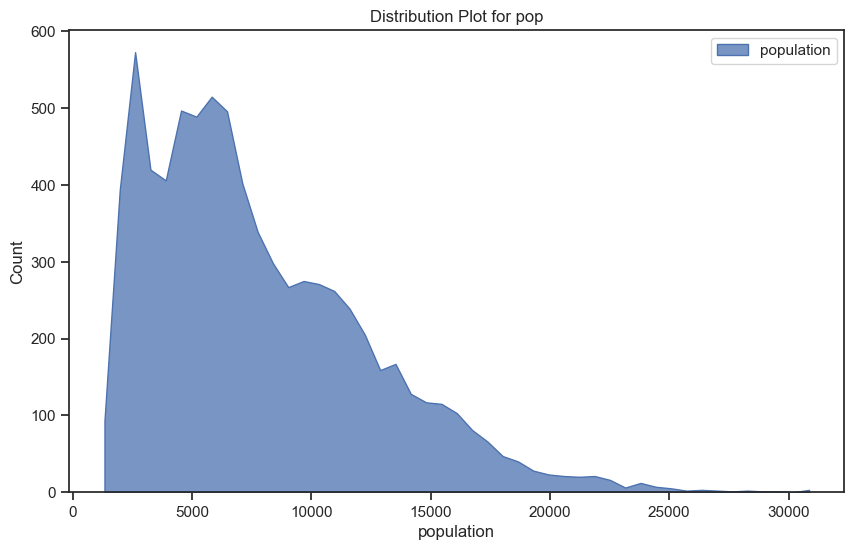

Skewness for pop:
{'population': 0.9998809901136609}
Kurtosis for pop:
{'population': 0.9084258742303115}




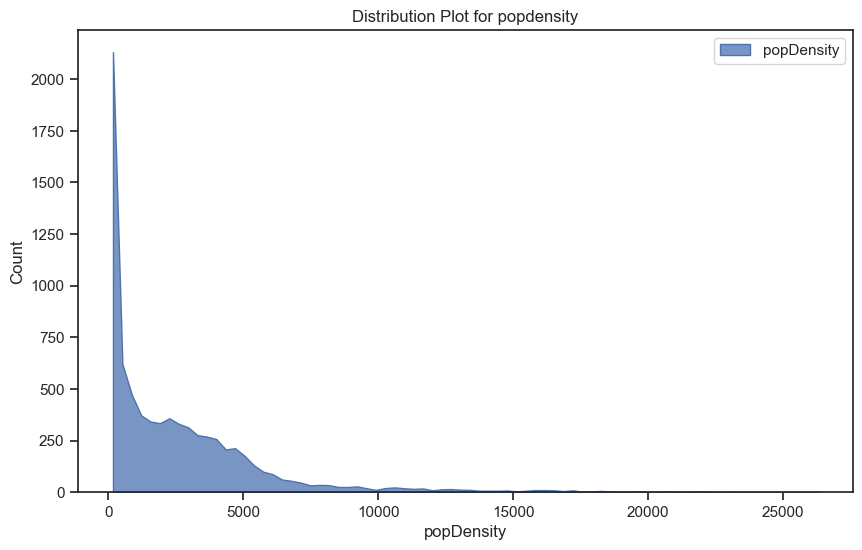

Skewness for popdensity:
{'popDensity': 2.3766150786462568}
Kurtosis for popdensity:
{'popDensity': 7.802978163662786}




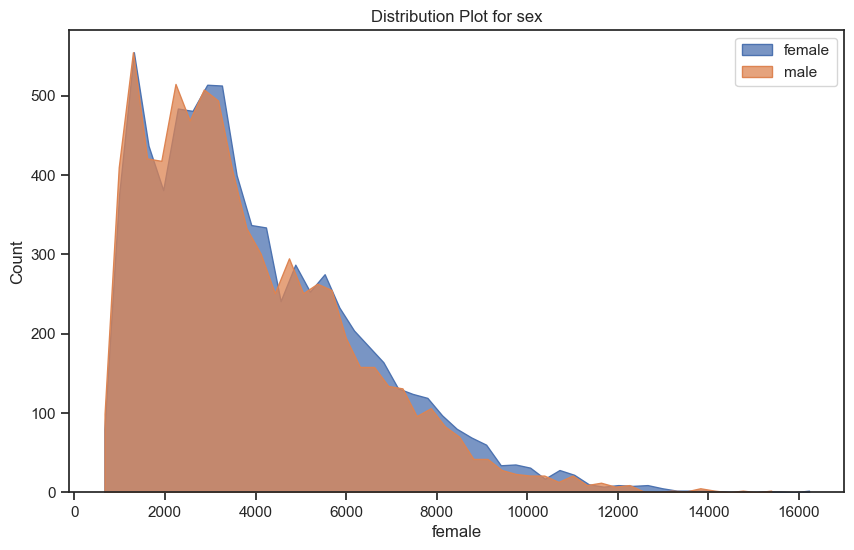

Skewness for sex:
{'female': 0.9871962054539031, 'male': 1.0239536608596043}
Kurtosis for sex:
{'female': 0.8621654565388868, 'male': 1.0130288844023125}




In [10]:
# Iterate over each indicator
for indicator, columns in indicator_columns.items():
    plt.figure(figsize=(10, 6))
    
    # Initialize dictionaries to store skewness and kurtosis
    skewness = {}
    kurtosis = {}

    # Plotting the histogram for each column within the indicator
    for col in columns:
        sns.histplot(merged_df[col], kde=False, label=col, element="poly", fill=True)

        # Calculate skewness and kurtosis
        skewness[col] = merged_df[col].skew()
        kurtosis[col] = merged_df[col].kurtosis()

    plt.title(f'Distribution Plot for {indicator}')
    plt.legend()
    plt.show()

    # Display skewness and kurtosis
    print(f'Skewness for {indicator}:')
    print(skewness)
    print(f'Kurtosis for {indicator}:')
    print(kurtosis)
    print("\n")


The above now shows the distribution plots of the the categories, as they are count data of the occurrences of the indicators and their categories in every local ward in the UK, all of them are negatively skewed. The skewneess will be kept unchanged because they are count data and there is a fear if they were log transformed or went through any transformation that changed their distribution, the raw data which reflects each local wards's unique profile will be distorted and we will lose interpretability. So what is done is that we will standardize all of the indicator groups except the health data group, this is to ensure that they are all on a similar scale, which makes it easier for future modeling. The health data group will be transformed into proportions instead. 

In [11]:
from sklearn.preprocessing import StandardScaler

# Define indicator groups with their respective columns
indicator_columns = {
    'accommodation': ['detached', 'semiDetached', 'terraced', 'flats', 'sharedHouse', 'conversion', 'commercial', 'caravan'],
    'deprivation': [ 'dep0', 'dep1', 'dep2', 'dep3', 'dep4'],
    'health': ['vGood', 'good', 'fair', 'bad', 'vBad'],
    'occupation': [ 'management', 'professional', 'technical', 'admin', 'skilledTrade', 'service', 'sales', 'manual', 'elementary'],
    'qualification': [ 'none_qualification', 'level1', 'level2', 'apprentice', 'level3', 'level4', 'other_qualification'],
    'socioeconomics': [ 'L1_L2_L3', 'L4_L5_L6', 'L7', 'L8_L9', 'L10_L11', 'L12', 'L13', 'L14', 'L15'],
    'vehicle': ['v0', 'v1', 'v2', 'v3plus'],
    'ethnicgroup': ['ABBangladeshi', 'ABChinese', 'ABIndian', 'ABPakistani', 'ABAsian', 'BBAfrican', 'BBCaribbean', 'BBBlack', 'whiteAndAsian', 'whiteAndBlackAfrican', 'whiteAndBlackCaribbean', 'multiple', 'wBritish', 'wIrish', 'wTraveller', 'wRoma', 'wOther', 'arab', 'other_ethnic'],
    'heating': ['none_heating', 'mainsGas', 'bottledGas', 'elec', 'oil', 'wood', 'solid', 'renewable', 'communal', 'other_heating', '2plusNonRenewable', '2plusRenewable'],
    'pop': ['population'],
    'popdensity': ['popDensity'],
    'sex': ['female', 'male']
}

# Iterate over each indicator and its columns
for indicator, cols in indicator_columns.items():
    if indicator != 'health':
        # Apply StandardScaler to each group of columns
        scaler = StandardScaler()
        merged_df[cols] = scaler.fit_transform(merged_df[cols])
    else:
        # Transform health columns to proportions instead of standardizing them
        health_sum = merged_df[cols].sum(axis=1)
        merged_df[cols] = merged_df[cols].div(health_sum, axis=0)

print(merged_df.head())


        code         areaName      cx      cy  detached  semiDetached  \
0  E05000650    Astley Bridge  370732  412836  0.966641      1.564969   
1  E05000653    Bromley Cross  371904  414137  2.609219      0.911970   
2  E05000654  Crompton Bolton  371830  410799 -0.455505      0.602654   
3  E05000657        Halliwell  370801  409673 -0.800375     -0.257829   
4  E05000658     Harper Green  371585  406271 -0.752378      3.191740   

   terraced     flats  sharedHouse  conversion  ...       oil      wood  \
0  1.334971 -0.145641    -0.251877    3.803084  ... -0.442458 -0.202465   
1  1.104304 -0.299663    -0.328859    2.404888  ... -0.451363 -0.443586   
2  3.717106  0.838113    -0.226217    0.207724  ... -0.402384 -0.564146   
3  3.181730  1.559781     0.232009    0.307595  ... -0.495890 -0.323025   
4  0.578896 -0.223894    -0.248211   -0.491374  ... -0.500343 -0.443586   

      solid  renewable  communal  other_heating  2plusNonRenewable  \
0 -0.199341  -0.625874 -0.061271       0

health columns were transformed into proportions for each location, instead of raw count data

In [12]:
# Define the columns for the 'health' group
health_columns = ['vGood', 'good', 'fair', 'bad', 'vBad']

# Print the values of the columns in the 'health' group
print(merged_df[health_columns].head())


      vGood      good      fair       bad      vBad
0  0.493883  0.327700  0.123966  0.042642  0.011810
1  0.528912  0.325907  0.107878  0.029974  0.007329
2  0.493943  0.317523  0.127225  0.046238  0.015071
3  0.475713  0.300971  0.145352  0.062039  0.015925
4  0.491481  0.322778  0.124568  0.047840  0.013333


Now we bring in geographical data to our dataframe, by reading the .json file of the local wards and load it into a new dataframe we create using the geopandas library, which will be called geo_data_gpd

In [13]:
topo_path = 'wards.json'
geo_data_gpd = gpd.read_file(topo_path)
print(geo_data_gpd.columns)


Index(['id', 'code', 'geometry'], dtype='object')


After succesfully loading, we merge the geo dataframe with merged_df by on a common key which is 'code', and then we name it merged_geo_df, and it is saved as a csv file, this file is the one that will be used in all our models. 

In [14]:
# Merge the dataframes on the common key
merged_geo_df = geo_data_gpd.merge(merged_df, on='code')
# Save the merged DataFrame as a CSV file in Google Drive
merged_geo_df.to_csv('merged_geo_df.csv', index=False)


Now we convert British National Grid (BNG) coordinates to WGS84 latitude and longitude coordinates. We use the pyproj library to define a transformation from the BNG system (EPSG:27700) to the global latitude-longitude system (EPSG:4326). The function bng_to_latlng_vectorized applies this transformation to easting and northing coordinates in a DataFrame, resulting in new columns for latitude and longitude. This is useful for mapping and spatial analysis in global coordinate systems.

In [15]:
from pyproj import Transformer

def bng_to_latlng_vectorized(easting, northing):
    # Create a transformer object for BNG (EPSG:27700) to WGS84 (EPSG:4326)
    transformer = Transformer.from_crs('epsg:27700', 'epsg:4326', always_xy=True)
    # Transform the coordinates
    lon, lat = transformer.transform(easting, northing)
    return lat, lon

# Convert coordinates for the entire DataFrame
merged_geo_df['latitude'], merged_geo_df['longitude'] = bng_to_latlng_vectorized(merged_geo_df['cx'], merged_geo_df['cy'])

This Python code uses the Dash framework to build an interactive web application for visualizing and analyzing geographical data. It features a dropdown menu for selecting demographic and socio-economic indicators, a slider to adjust the number of clusters, and a map for displaying the results. The app employs KMeans clustering to group data and Plotly Express for visualizations. It includes functionality to calculate and present cluster centroids, health indicators distributions, and clustering quality scores (Silhouette, Davies-Bouldin, and Calinski-Harabasz). The interactive nature allows us to dynamically explore spatial patterns in various indicators, enhancing understanding of geographical data relationships as well as their statistical characteristics.

In [17]:
import dash
from dash import dcc, html, Input, Output, dash_table
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Initialize the Dash app
app = dash.Dash(__name__)

indicator_groups = {
    'accommodation': ['detached', 'semiDetached', 'terraced', 'flats', 'sharedHouse', 'conversion', 'commercial', 'caravan'],
    'deprivation': [ 'dep0', 'dep1', 'dep2', 'dep3', 'dep4'],
    'health': ['vGood', 'good', 'fair', 'bad', 'vBad'],
    'occupation': [ 'management', 'professional', 'technical', 'admin', 'skilledTrade', 'service', 'sales', 'manual', 'elementary'],
    'qualification': [ 'none_qualification', 'level1', 'level2', 'apprentice', 'level3', 'level4', 'other_qualification'],
    'socioeconomics': [ 'L1_L2_L3', 'L4_L5_L6', 'L7', 'L8_L9', 'L10_L11', 'L12', 'L13', 'L14', 'L15'],
    'vehicle': ['v0', 'v1', 'v2', 'v3plus'],
    'ethnicgroup': ['ABBangladeshi', 'ABChinese', 'ABIndian', 'ABPakistani', 'ABAsian', 'BBAfrican', 'BBCaribbean', 'BBBlack', 'whiteAndAsian', 'whiteAndBlackAfrican', 'whiteAndBlackCaribbean', 'multiple', 'wBritish', 'wIrish', 'wTraveller', 'wRoma', 'wOther', 'arab', 'other_ethnic'],
    'heating': ['none_heating', 'mainsGas', 'bottledGas', 'elec', 'oil', 'wood', 'solid', 'renewable', 'communal', 'other_heating', '2plusNonRenewable', '2plusRenewable'],
    'pop': ['population'],
    'popdensity': ['popDensity'],
    'sex': ['female', 'male']
}
# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='indicator-dropdown',
        options=[{'label': i, 'value': i} for i in indicator_groups.keys()],
        value=list(indicator_groups.keys())[0]
    ),
    dcc.Slider(
        id='cluster-slider',
        min=2,
        max=10,
        step=1,
        value=5
    ),
    dcc.Graph(id='map-plot', style={'height': '65vh', 'width': '100%'}),
    html.Div(id='cluster-analysis', style={'max-height': '10vh', 'overflow-y': 'auto'}),
    html.Div(id='health-distribution', style={'max-height': '10vh', 'overflow-y': 'auto'}),
    html.Div(id='cluster-scores', style={'max-height': '10vh', 'overflow-y': 'auto'}),  # Added component for cluster scores

], style={'display': 'flex', 'flex-direction': 'column', 'height': '100vh'})

# Combined Callback
@app.callback(
    [Output('map-plot', 'figure'),
     Output('cluster-analysis', 'children'),
     Output('health-distribution', 'children'),
     Output('cluster-scores', 'children')],  # Added output for cluster scores table
    [Input('indicator-dropdown', 'value'),
     Input('cluster-slider', 'value')]
)
def update_map_analysis(selected_indicator, num_clusters):
    # Perform clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(merged_geo_df[indicator_groups[selected_indicator]])
    merged_geo_df[f"{selected_indicator}_cluster"] = cluster_labels

    # Create the map
    fig = px.scatter_mapbox(
        merged_geo_df,
        lat="latitude",
        lon="longitude",
        hover_name='areaName',
        color=f"{selected_indicator}_cluster",
        color_continuous_scale=px.colors.diverging.BrBG,
        size_max=20,
        zoom=5,
        mapbox_style="carto-darkmatter"
    )
    fig.update_layout(autosize=True)

    # Cluster analysis table
    centroids = kmeans.cluster_centers_
    centroid_df = pd.DataFrame(centroids, columns=indicator_groups[selected_indicator]).round(4)
    centroid_df['Cluster ID'] = range(num_clusters)
    column_order = ['Cluster ID'] + list(centroid_df.columns[:-1])
    centroid_df = centroid_df[column_order]
    cluster_analysis_table = html.Table(
        [html.Tr([html.Th(col, style={'border': '1px solid black', 'font-size': '11px'}) for col in centroid_df.columns])] +
        [html.Tr([html.Td(centroid_df.iloc[i][col], style={'border': '1px solid black', 'font-size': '11px'}) for col in centroid_df.columns]) for i in range(len(centroid_df))],
        style={'border-collapse': 'collapse', 'width': '100%', 'table-layout': 'fixed'}
    )

    health_summary = merged_geo_df.groupby(f"{selected_indicator}_cluster")[indicator_groups['health']].sum()
    # Normalize each column in health_summary
    health_summary_normalized = health_summary.div(health_summary.sum(axis=1), axis=0).round(4).reset_index()
    
    # Health distribution table
    health_table = html.Table(
        [html.Tr([html.Th(col, style={'border': '1px solid black', 'font-size': '11px'}) for col in health_summary_normalized.columns])] +
        [html.Tr([html.Td(health_summary_normalized.iloc[i][col], style={'border': '1px solid black', 'font-size': '11px'}) for col in health_summary_normalized.columns]) for i in range(len(health_summary_normalized))],
        style={'border-collapse': 'collapse', 'width': '100%', 'table-layout': 'fixed'}
    )
    
    # Calculate clustering scores
    silhouette_avg = silhouette_score(merged_geo_df[indicator_groups[selected_indicator]], cluster_labels)
    davies_bouldin_avg = davies_bouldin_score(merged_geo_df[indicator_groups[selected_indicator]], cluster_labels)
    calinski_harabasz_avg = calinski_harabasz_score(merged_geo_df[indicator_groups[selected_indicator]], cluster_labels)

    # Cluster scores table
    scores_data = {
        'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'],
        'Score': [silhouette_avg, davies_bouldin_avg, calinski_harabasz_avg]
    }
    scores_df = pd.DataFrame(scores_data)
    cluster_scores_table = html.Table(
        [html.Tr([html.Th(col, style={'border': '1px solid black', 'font-size': '11px'}) for col in scores_df.columns])] +
        [html.Tr([html.Td(scores_df.iloc[i][col], style={'border': '1px solid black', 'font-size': '11px'}) for col in scores_df.columns]) for i in range(len(scores_df))],
        style={'border-collapse': 'collapse', 'width': '100%', 'table-layout': 'fixed'}
    )


    return fig, cluster_analysis_table, health_table, cluster_scores_table

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
